### Install kagglehub to download data from Kaggle

In [126]:
!pip install kagglehub > /dev/null 2>&1

### Download Kaggle data

In [132]:
import kagglehub
import shutil
import os

path = kagglehub.dataset_download("jinquan/cc-sample-data")

print("Path to file:", path)

100%|██████████| 210M/210M [01:52<00:00, 1.96MB/s]   

Extracting files...


Path to file: /home/jovyan/.cache/kagglehub/datasets/jinquan/cc-sample-data/versions/1


In [133]:
import os

for file in os.listdir(path):
    shutil.move(f'{path}/{file}', f'/home/jovyan/work/kaggle/{file}')

### Import libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, DecimalType
from pyspark.sql.functions import col, from_unixtime, from_json, expr, to_date, to_timestamp, split, regexp_replace, trim, from_utc_timestamp, date_format, udf

### Create Spark session and define schemas for the JSON data

In [2]:
spark = SparkSession.builder \
    .appName("cc_trans") \
    .config("spark.ui.port", "4040") \
    .config("spark.sql.parquet.datetimeRebaseModeInWrite", "CORRECTED") \
    .config("spark.sql.parquet.int96RebaseModeInWrite", "CORRECTED") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .config("mapreduce.fileoutputcommitter.marksuccessfuljobs", "false") \
    .config("spark.sql.parquet.compression.codec", "zstd") \
    .getOrCreate()

schema = StructType([
    StructField("Unnamed: 0", StringType()),
    StructField("trans_date_trans_time", StringType()),
    StructField("cc_bic", StringType()),
    StructField("cc_num", StringType()),
    StructField("merchant", StringType()),
    StructField("category", StringType()),
    StructField("amt", DecimalType(10, 2)),
    StructField("personal_detail", StringType()),
    StructField("trans_num", StringType()),
    StructField("merch_lat", DecimalType(9, 6)),
    StructField("merch_long", DecimalType(9, 6)),
    StructField("is_fraud", StringType()),
    StructField("merch_zipcode", StringType()),
    StructField("merch_eff_time", StringType()),
    StructField("merch_last_update_time", StringType())
])

personal_detail_schema = StructType([
    StructField("person_name", StringType()),
    StructField("gender", StringType()),
    StructField("address", StringType()),
    StructField("lat", DecimalType(7, 4)),
    StructField("long", DecimalType(7, 4)),
    StructField("city_pop", StringType()),
    StructField("dob", StringType()),
])

address_schema = StructType([
    StructField("street", StringType()),
    StructField("city", StringType()),
    StructField("state", StringType()),
    StructField("zip", StringType())
])

### Load the JSON file into dataframe

In [ ]:
df = spark.read.format("json").schema(schema).load(f"/home/jovyan/work/kaggle/cc_sample_transaction.json")

In [ ]:
df = df.withColumn('personal_detail', from_json(col('personal_detail'), personal_detail_schema))
df = df.withColumn('address', from_json(col('personal_detail.address'), address_schema))

df = df.select(
    col("Unnamed: 0"),
    col("trans_date_trans_time"),
    col("cc_bic"),
    col("cc_num"),
    col("merchant"),
    col("category"),
    col("amt"),
    col("personal_detail.person_name").alias("person_name"),
    col("personal_detail.gender").alias("gender"),
    col("address.street").alias("street"),
    col("address.city").alias("city"),
    col("address.state").alias("state"),
    col("address.zip").alias("zip"),
    col("personal_detail.lat").alias("lat"),
    col("personal_detail.long").alias("long"),
    col("personal_detail.city_pop").alias("city_pop"),
    col("personal_detail.dob").alias("dob"),
    col("trans_num"),
    col("merch_lat"),
    col("merch_long"),
    col("is_fraud"),
    col("merch_zipcode"),
    col("merch_eff_time"),
    col("merch_last_update_time")
)

df = df.withColumn("Unnamed: 0", col("Unnamed: 0").cast(IntegerType()))
df = df.withColumn("is_fraud", col("is_fraud").cast(BooleanType()))
df = df.withColumn("city_pop", col("city_pop").cast(IntegerType()))

In [122]:
df = df.withColumn('trans_date_trans_time', to_timestamp('trans_date_trans_time', 'yyyy-MM-dd HH:mm:ss')) \
    .withColumn("trans_date_trans_time", from_utc_timestamp(col("trans_date_trans_time"), "Asia/Kuala_Lumpur")) \
    .withColumn("trans_date_trans_time", date_format(col("trans_date_trans_time"), "yyyy-MM-dd HH:mm:ss XXX"))

df = df.withColumn("merch_last_update_time", to_timestamp(from_unixtime(col("merch_last_update_time") / 1000), 'yyyy-MM-dd HH:mm:ss')) \
    .withColumn("merch_last_update_time", from_utc_timestamp(col("merch_last_update_time"), "Asia/Kuala_Lumpur")) \
    .withColumn("merch_last_update_time", date_format(col("merch_last_update_time"), "yyyy-MM-dd HH:mm:ss.SSS XXX"))

df = df.withColumn("merch_eff_time", to_timestamp(from_unixtime(col("merch_eff_time") / 1000000), 'yyyy-MM-dd HH:mm:ss')) \
    .withColumn("merch_eff_time", from_utc_timestamp(col("merch_eff_time"), "Asia/Kuala_Lumpur")) \
    .withColumn("merch_eff_time", date_format(col("merch_eff_time"), "yyyy-MM-dd HH:mm:ss.SSS XXX"))

df = df.withColumn('dob', to_date('dob', 'yyyy-MM-dd'))

df = df.withColumn("person_name", regexp_replace(col("person_name"), r"[@|,]|!+", ",")) \
        .withColumn("first_name", trim(split(col("person_name"), ",")[0])) \
        .withColumn("last_name", trim(split(col("person_name"), ",")[1])) \
        .drop("person_name")

In [123]:
from hashlib import sha256

def hash_pii(value):
    return sha256(value.encode()).hexdigest() if value else None

hash_udf = udf(hash_pii, StringType())

In [124]:
df = df.withColumn('cc_num', hash_udf("cc_num"))

In [125]:
df.show(1, truncate=False, vertical=True)

-RECORD 0----------------------------------------------------------------------------------
 Unnamed: 0             | 0                                                                
 trans_date_trans_time  | 2019-01-01 08:00:18 Z                                            
 cc_bic                 | CITIUS33CHI                                                      
 cc_num                 | 80923ef01336409c8bfd3f8f5689196742e2c9871c0275e6cf5733d0facfd843 
 merchant               | fraud_Rippin, Kub and Mann                                       
 category               | misc_net                                                         
 amt                    | 4.97                                                             
 gender                 | F                                                                
 street                 | 561 Perry Cove                                                   
 city                   | Moravian Falls                                        

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 51048)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/usr/local/spark/python/pyspark/accumulators.py", line 271, in accum_updates
    num_updates =

In [17]:
df.coalesce(1).write.mode("overwrite").parquet('/home/jovyan/work/kaggle/output/')

In [1]:
spark.stop()

NameError: name 'spark' is not defined

In [60]:
import pandas as pd
import os

df = pd.DataFrame()

for file in os.listdir('/home/jovyan/work/kaggle/output/'):
    if file.endswith('.parquet'):
        df_temp = pd.read_parquet('/home/jovyan/work/kaggle/output/' + file, columns=["trans_date_trans_time", "merchant", "category", "amt", "gender", "state", "zip", "lat", "long", "city_pop", "merch_lat", "merch_long", "is_fraud"])
        df = pd.concat([df, df_temp], axis=0)

In [3]:
df.head()

,trans_date_trans_time,merchant,category,amt,gender,state,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud
0,2019-01-01 08:00:18 Z,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,NC,28654,36.0788,-81.1781,3495,36.011293,-82.048315,False
1,2019-01-01 08:00:44 Z,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,WA,99160,48.8878,-118.2105,149,49.159047,-118.186462,False
2,2019-01-01 08:00:51 Z,fraud_Lind-Buckridge,entertainment,220.11,M,ID,83252,42.1808,-112.2620,4154,43.150704,-112.154481,False
3,2019-01-01 08:01:16 Z,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,MT,59632,46.2306,-112.1138,1939,47.034331,-112.561071,False
4,2019-01-01 08:03:06 Z,fraud_Keeling-Crist,misc_pos,41.96,M,VA,24433,38.4207,-79.4629,99,38.674999,-78.632459,False


In [4]:
import matplotlib.pyplot as plt

In [41]:
import kagglehub

path = kagglehub.dataset_download("francescopettini/us-state-names-codes-and-abbreviations")

print("Path to file:", path)

100%|██████████| 830/830 [00:00<00:00, 1.26MB/s]

Extracting files...
Path to file: /home/jovyan/.cache/kagglehub/datasets/francescopettini/us-state-names-codes-and-abbreviations/versions/2


In [47]:
os.listdir('/home/jovyan/.cache/kagglehub/datasets/francescopettini/us-state-names-codes-and-abbreviations/versions/2')

['state_names.csv']

In [50]:
shutil.move('/home/jovyan/.cache/kagglehub/datasets/francescopettini/us-state-names-codes-and-abbreviations/versions/2/state_names.csv', '/home/jovyan/work/kaggle/state_names.csv')

'/home/jovyan/work/kaggle/state_names.csv'

In [63]:
state_code_list = pd.read_csv('/home/jovyan/work/kaggle/state_names.csv', usecols=['State', 'Alpha code'])
state_code_list.rename(columns={'State': 'full_state', 'Alpha code': 'state'}, inplace=True)

In [65]:
df_joined = pd.merge(df, state_code_list, left_on='state', right_on='state', how='left')

In [66]:
df_joined

,trans_date_trans_time,merchant,category,amt,gender,state,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,full_state
0,2019-01-01 08:00:18 Z,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,NC,28654,36.0788,-81.1781,3495,36.011293,-82.048315,False,North Carolina
1,2019-01-01 08:00:44 Z,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,WA,99160,48.8878,-118.2105,149,49.159047,-118.186462,False,Washington
2,2019-01-01 08:00:51 Z,fraud_Lind-Buckridge,entertainment,220.11,M,ID,83252,42.1808,-112.2620,4154,43.150704,-112.154481,False,Idaho
3,2019-01-01 08:01:16 Z,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,MT,59632,46.2306,-112.1138,1939,47.034331,-112.561071,False,Montana
4,2019-01-01 08:03:06 Z,fraud_Keeling-Crist,misc_pos,41.96,M,VA,24433,38.4207,-79.4629,99,38.674999,-78.632459,False,Virginia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 20:12:08 Z,fraud_Reichel Inc,entertainment,15.56,M,UT,84735,37.7175,-112.4777,258,36.841266,-111.690765,False,Utah
1296671,2020-06-21 20:12:19 Z,fraud_Abernathy and Sons,food_dining,51.70,M,MD,21790,39.2667,-77.5101,100,38.906881,-78.246528,False,Maryland
1296672,2020-06-21 20:12:32 Z,fraud_Stiedemann Ltd,food_dining,105.93,M,NM,88325,32.9396,-105.8189,899,33.619513,-105.130529,False,New Mexico
1296673,2020-06-21 20:13:36 Z,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,M,SD,57756,43.3526,-102.5411,1126,42.788940,-103.241160,False,South Dakota


In [67]:
is_fraud_by_gender = df_joined.groupby("gender")["is_fraud"].sum()

In [79]:
is_fraud_by_state = df_joined.groupby("full_state")["is_fraud"].sum().sort_values(ascending=True)

In [69]:
is_fraud_by_category = df_joined.groupby("category")["is_fraud"].sum().sort_values(ascending=False)

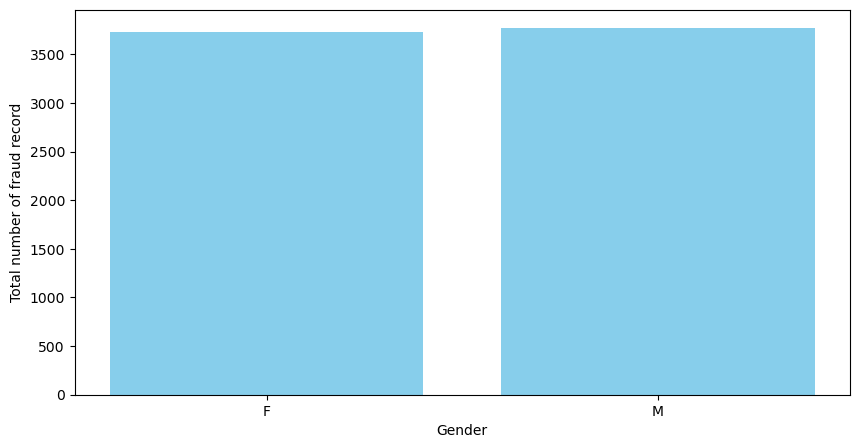

In [39]:
# Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(is_fraud_by_gender.index, is_fraud_by_gender.values, color='skyblue')
plt.xlabel("Gender")
plt.ylabel("Total number of fraud record")
plt.show()

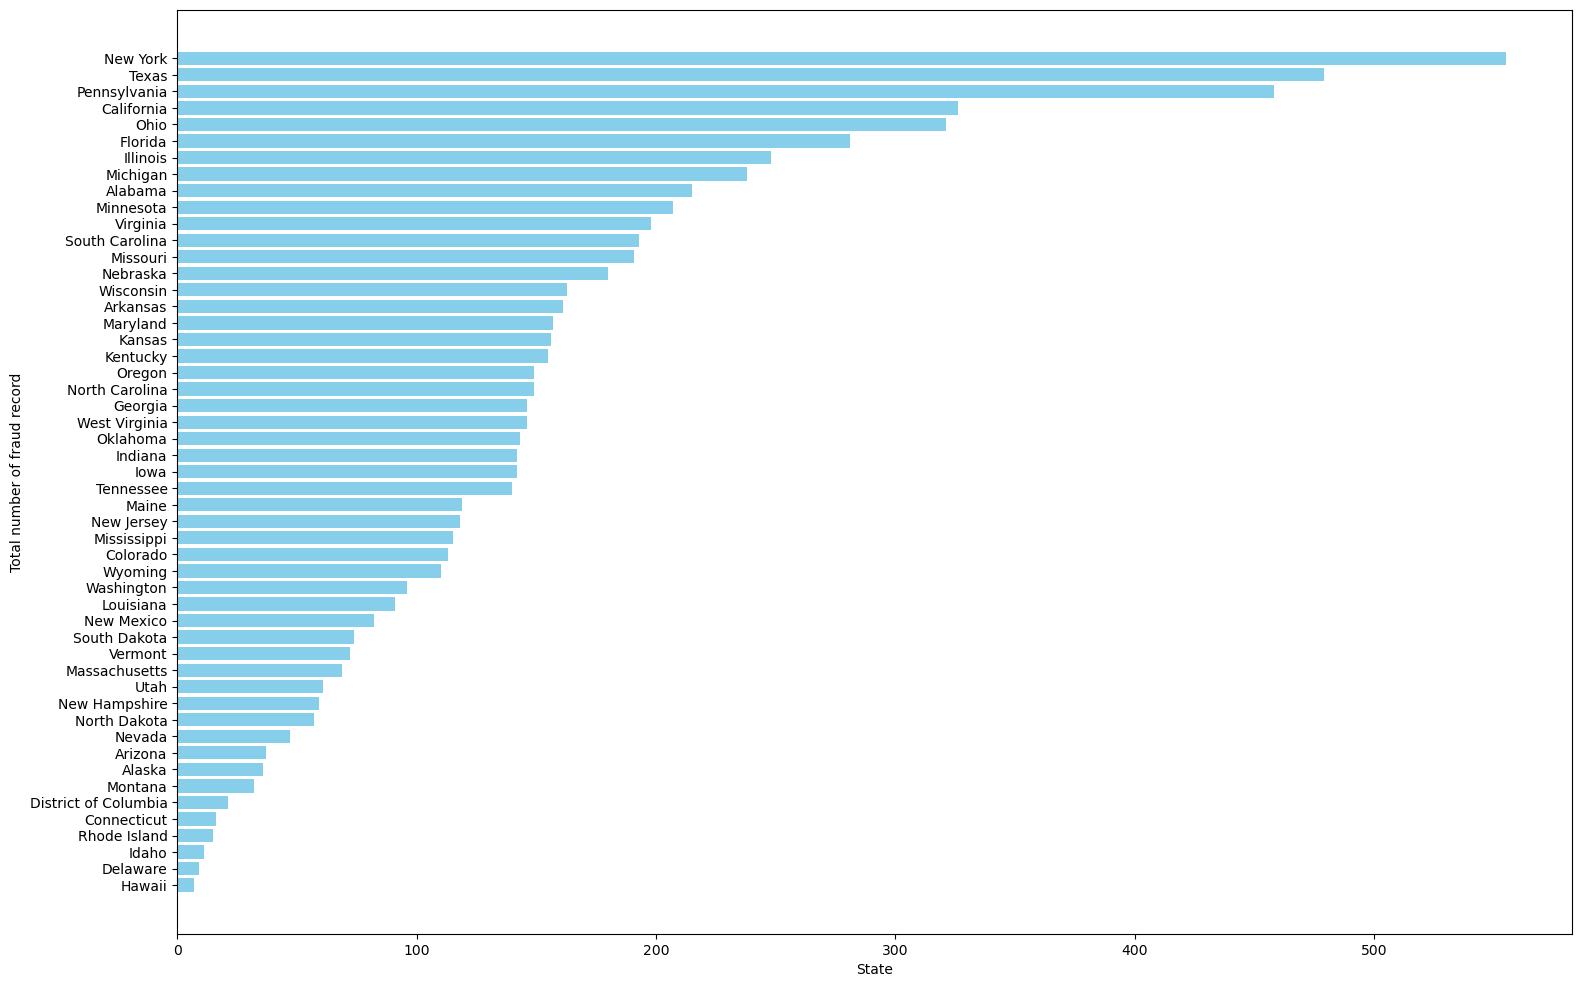

In [104]:
# Bar Chart
plt.figure(figsize=(18, 12))
plt.barh(is_fraud_by_state.index, is_fraud_by_state.values, color='skyblue')
plt.xlabel("State")
plt.ylabel("Total number of fraud record")
plt.show()

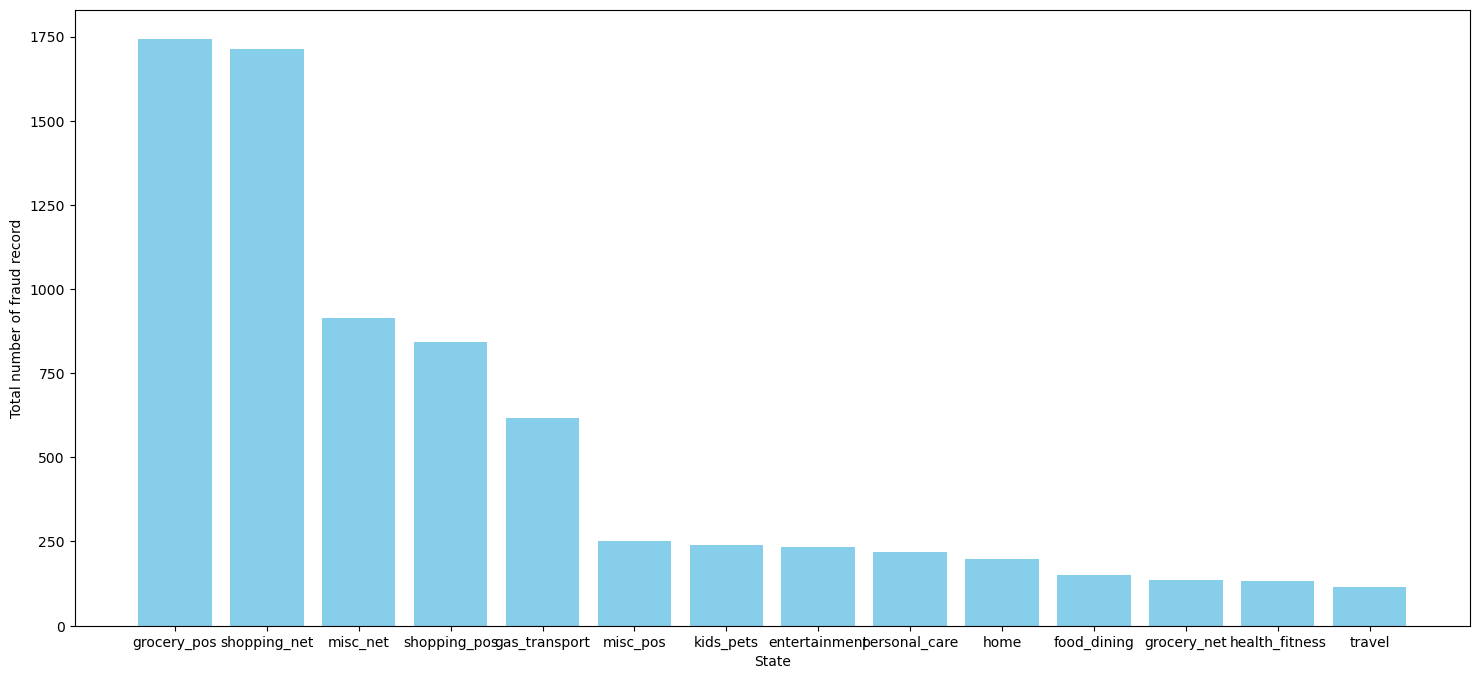

In [46]:
# Bar Chart
plt.figure(figsize=(18, 8))
plt.bar(is_fraud_by_category.index, is_fraud_by_category.values, color='skyblue')
plt.xlabel("State")
plt.ylabel("Total number of fraud record")
plt.show()

In [106]:
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 1.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 1.3 MB/s eta 0:00:0000:0100:060m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 1.1 MB/s eta 0:00:00eta 0:00:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 2.0 MB/s eta 0:00:0000:0100:01


In [108]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 921.6 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 1.3 MB/s eta 0:00:00a 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 352.6 kB/s eta 0:00:00a 0:00:01


In [109]:
!pip install shapely

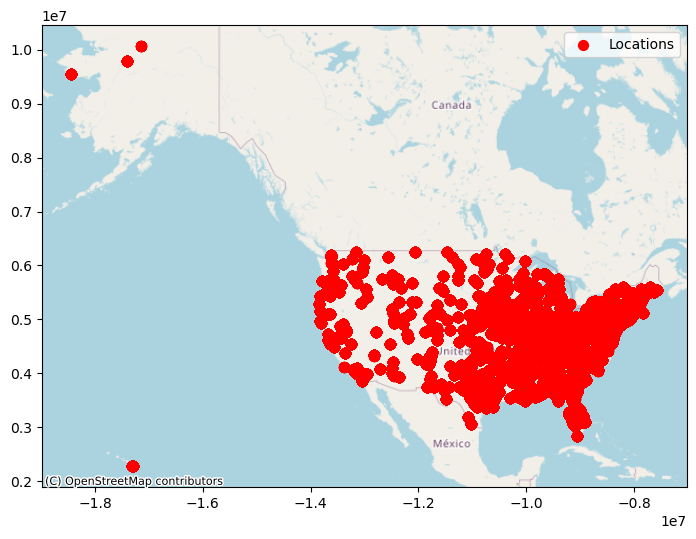

In [110]:
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df_joined, geometry=gpd.points_from_xy(df_joined.long, df_joined.lat), crs="EPSG:4326")

# Convert to Web Mercator for map overlay
gdf = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, color='red', marker='o', markersize=50, label="Locations")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.legend()
plt.show()
